# PyMC Program Analysis

PyMC is a python library which focuses on probabilistic programming, while providing higher level functions which abstract away some of the lower level statistics, thus making it more accessible.

## Markov Chain Monte Carlo

PyMC stands for Python Markov chain Monte Carlo. MCMC (Markov chain Monte Carlo) is a class of algorithms which is used for sampling a distribution of possible values repeatedly to gain statistical insights. MCMC is derived from combining Monte Carlo with Markov chains. Normally Monte Carlo algorithms take repeated random samples to create a sort of simulation. The Monte Carlo has a combination of set rules for example a model of the environment in question and then variables with random variance, the combination of these factors creates some outcome.

A Markov chain is a list of values which have a probability of occuring, after one value occurs the probability of the next value is dependent on the current value. For example consider a bag with 2 red balls, 2 blue, and 2 yellow. When choosing the first value there is a chance of ⅓ of choosing any color. Say the first color chosen is red and now we have to recalculate the odds of what type of ball will be selected next. Since the bag now contains only 1 red ball there is a reduced chance of another red ball and an increased chance of blue and yellow.

MCMC uses a Monte Carlo style simulation but incorporates Markov chains by having each result effect the proceeding result.

## Coin Flip Simulation

This beggins with importing PyMC, deciding on the number of trials *(times we will flip the coin, in this case 10)*, choose a theta value *(this represents the unknown probability in our case we will assume the coin is fair and will come up heads 50% of the time)*. After deciding on these values we create our `flips` variable which will contain a distribution of `1`s and `0`s, where `1` represents heads and `0` represents tails. With this value set we will get back an array containing the result from each flip.

The data from our coin flip simulation will be gathered using Bernoulli from `scipy` *(Bernoulli simply refers to a test which can return either true or false)*. Note that in a real use case we wouldn't know the theta value and our data would be generated from some other method for example actually recording coin flips, or recording some other real world data where we want to find the value of theta.

In [45]:
import scipy as sp
import numpy as np
import warnings
warnings.filterwarnings("ignore")

np.random.seed(seed=123)

trials = 10
theta_real = 0.50 # unknown value in a real experiment
flips = sp.stats.bernoulli.rvs(p=theta_real, size=trials)
flips

array([1, 0, 0, 1, 1, 0, 1, 1, 0, 0])

Now that we have our initial test data we'll create a model for testing the data. The model requires a Beta value which represents the expected value before looking at the observed data. For an expectation of 50/50 we'll pass in `alpha=1` and `beta=1`to `pm.Beta` and have it represented as `θ`.

***Note: When applying Bayes theorm there is also a requirment for a prior expectation or "guess", when no information is known a middle of the road exepected value is chosen at random. However in the case of flipping a coin an expectation of 50/50 is rational.***

We then tell our model to take Bernoulli samples from the observed data `flips` while keeping in mind the expectation of a 50/50 result.

To get the results we use our model `pm` to take 1000 samples from the provided data set `flips`.

In [18]:
import pymc3 as pm

with pm.Model() as our_first_model:
  θ = pm.Beta('θ', alpha=1., beta=1.)
  y = pm.Bernoulli('y', p=θ, observed=flips)
  trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 1494.96it/s]


In order to visualize the results of our model, saved as `trace`, we'll import `arviz`. In addition to being able to visually graph our results we can dump the results.

In [19]:
import arviz as az

az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.502,0.136,0.228,0.733,0.005,0.004,727.0,716.0,755.0,1268.0,1.0


However what if the coin we're testing is actually a rigged coin which is made in a way that causes heads to come up more than tails? The initial expectation of the model would still be 50/50 but the observed data would instead reflect something different. Let's create a new data set using a coin which is 70/30 and make 100 flips. This larger number of flips will lower the odds that the outcome will appear fair by chance.

In [27]:
trials = 100
theta_real = 0.7
flips = sp.stats.bernoulli.rvs(p=theta_real, size=trials)
flips.sum()

70

Now that we have our data for observations of a fixed coin let's redo the model. The line `flips.sum()` will return the total number of heads observed out of 100.

In [26]:
with pm.Model() as our_first_model:
  θ = pm.Beta('θ', alpha=1., beta=1.)
  y = pm.Bernoulli('y', p=θ, observed=flips)
  trace = pm.sample(1000, random_seed=123)

az.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:00<00:00, 1572.40it/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.695,0.043,0.612,0.775,0.001,0.001,965.0,945.0,956.0,1521.0,1.0


We can see that despite our initial expectations of a 50/50 split between heads or tales the model has now realized the mean is closer to `0.7`.

We can also graph the expectation of having results between 45-55% results as heads against the models certainty that the theta value is within that range. As you can see the odds of the coin really being a fair one are pretty low. There is a small chance that it could be anywhere between 61% to 77% but our expected value of 50/50 is far outside the realm of liklihood.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e34e17da0>],
      dtype=object)

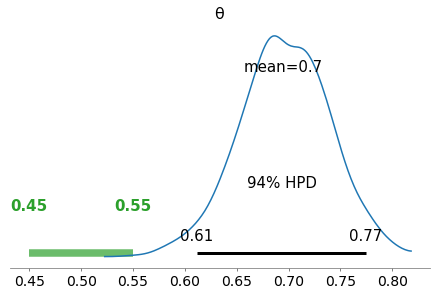

In [31]:
az.plot_posterior(trace, rope=[0.45, .55])

Now that we've seen how sampling works with PyMC, let's import some data that can be used for creating a Bayesian network. We'll use a dataset for tips which comes with a library called `seaborn`. It includes total bill, tip amount, gender, if a smoker, day, time, and size of party. It has a total of 243 entries.

In [52]:
import seaborn as sns
tips = sns.load_dataset('tips')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


`seaborn` can also be used to visualize our data for example we will plot tip amount against the amount of people in a party.

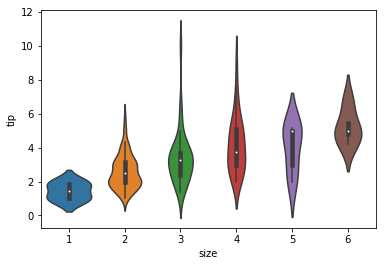

In [61]:
sns.violinplot(x='size', y='tip', data=tips)

We'll move the tip values into their own variable `tip` and count the unique values for group size as `size`.

In [64]:
import pandas as pd

tip = tips['tip'].values
idx = pd.Categorical(tips['size'],
  categories=[1, 2, 3, 4, 5, 6]).codes

size = len(np.unique(tips['size'].values))
idx

array([1, 2, 2, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 2, 2, 2, 2, 1, 1,
       1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       3, 1, 1, 3, 2, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 3, 2, 2,
       1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 1, 2, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 5, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 4, 5, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3,
       3, 4, 5, 3, 1, 3, 3, 1, 2, 1, 1, 2, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 1, 2, 3, 1, 4, 2, 4, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 2, 1, 1, 1, 3, 2, 2, 3, 1, 1, 2, 3, 3, 1, 2, 1, 4, 1, 1, 3,
       1, 1, 0, 2, 1, 1, 1, 3, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
       1, 1], dtype=int8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]
Sampling chain 1, 0 divergences: 100%|██████████| 5500/5500 [00:10<00:00, 537.60it/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e1cac3780>,
      dtype=object)

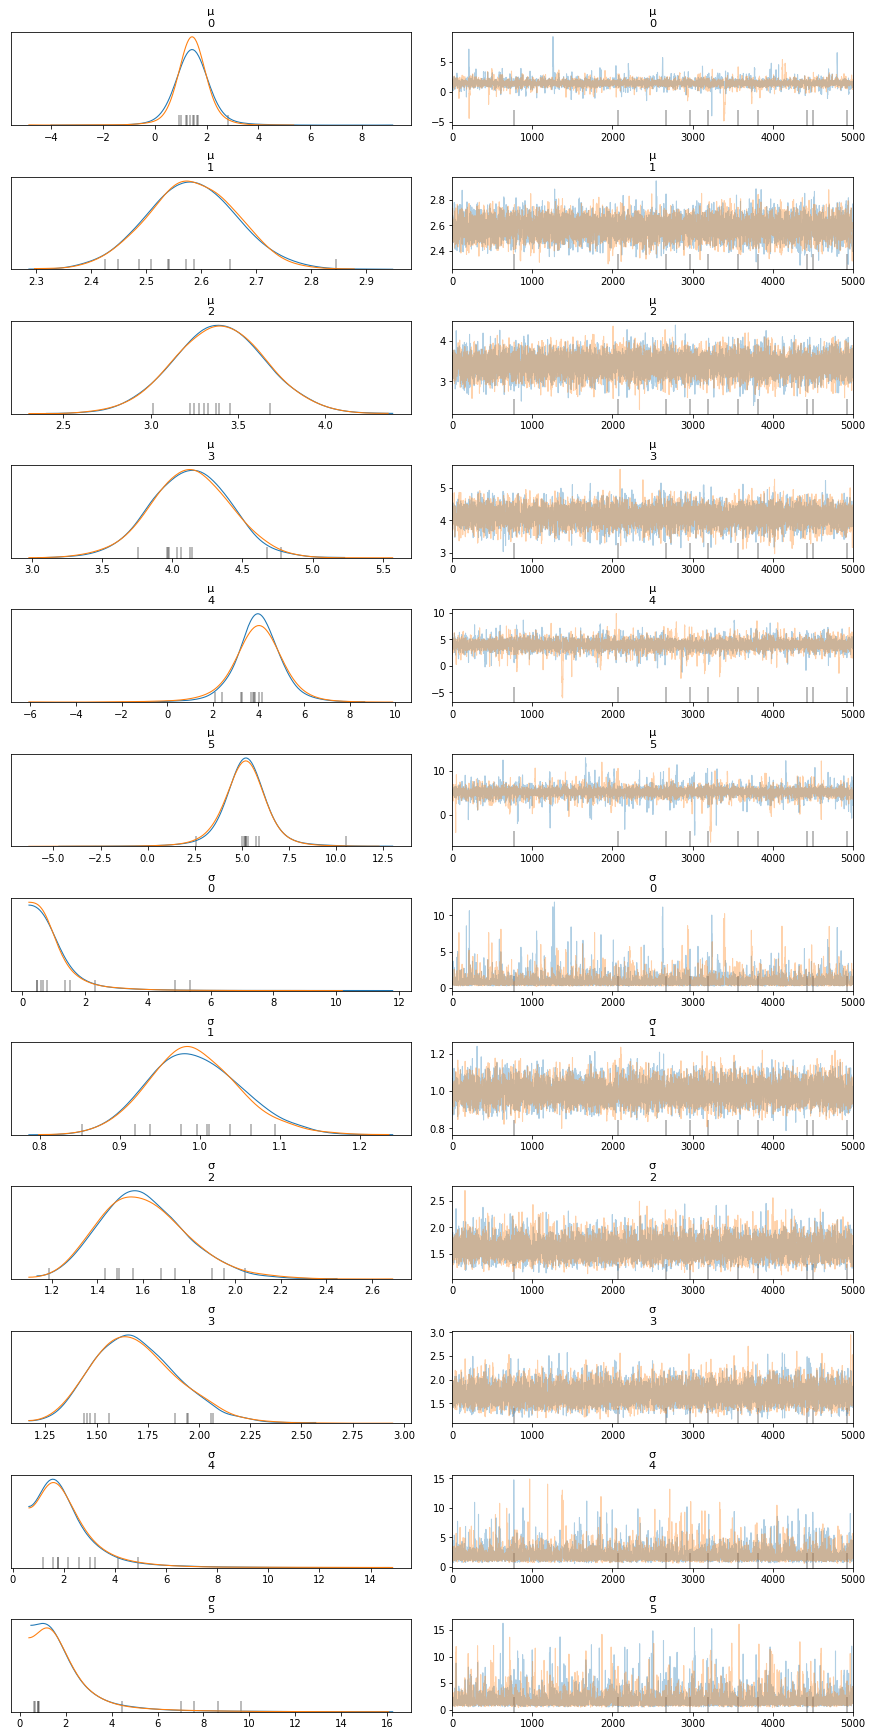

In [65]:
with pm.Model() as comparing_size:
  μ = pm.Normal('μ', mu=0, sd=10, shape=size)
  σ = pm.HalfNormal('σ', sd=10, shape=size)
  y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)
  trace_cg = pm.sample(5000)

az.plot_trace(trace_cg)

The first 6 graphs above show the sample distribution of tip amount given group size *(0 is for group size 1 due to index starting at 0)*. Below these first 6 graphs is another set of 6 which displays the standard deviation for each group. The right column on each row is a visualization of the sample process at each step.

Notice the similarities between these distributions and graphs shown with `sns.violinplot`.

There are several uses of PyMC which relate to the use of Bayes theorm. However it should be noted that the library is not generally used for Bayesian networks. Rather it is mainly used when a dataset exists for which the probabilities which control the outcome are unknown. Given a large dataset, a list of variables which control the outcome, the probabilities of the effect of those variables can be estimated.

**Sources**

*Martin, O. (2016). Bayesian analysis with Python. Birmingham, UK: Packt Publishing.*